In [1]:
#import pkgs
import pandas as pd
import numpy as np
import requests
import string
import nltk
import matplotlib.pyplot as plt
from io import BytesIO
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#load data from github
url = 'https://raw.githubusercontent.com/cmcswiggan/CIND820/main/SMS_Spam_Dataset'
data = requests.get(url).content
smsData = pd.read_csv(BytesIO(data), sep = '\t', header = None, names = ['Category', 'SMS Message'])

#check data loaded as expected
smsData.head()

,Category,SMS Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#assign stopwords and punctuation to variables
stopWords = nltk.corpus.stopwords.words('english')
punctuation = string.punctuation

In [5]:
#pre_Process function defined - list required for lemmatization step

def pre_Process(sms):
    
    #toeknize and remove stopwords
    tokenize = nltk.tokenize.word_tokenize(sms)
    remove_stopwords = [word for word in tokenize if word not in stopWords]
    return remove_stopwords

#add processed column
smsData['Processed'] = smsData['SMS Message'].apply(lambda x: pre_Process(x))

#check dataframe data as anticipated
smsData.head()

,Category,SMS Message,Processed
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, jurong, point, ,, crazy, .., Available, b..."
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, ..., Joking, wif, u, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, early, hor, ..., U, c, already, ..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[Nah, I, n't, think, goes, usf, ,, lives, arou..."


In [6]:
#define function for lemmatizing words

def lemm (sms):
    
    lem = [lemmatizer.lemmatize(word) for word in sms]
    return lem

#replace processed column with lemmatized column
smsData['Processed'] = smsData['Processed'].apply(lambda x: lemm(x))

#check dataframe data as anticipated
smsData.head()

,Category,SMS Message,Processed
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, jurong, point, ,, crazy, .., Available, b..."
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, ..., Joking, wif, u, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, early, hor, ..., U, c, already, ..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[Nah, I, n't, think, go, usf, ,, life, around,..."


In [7]:
#add cell with processed data as a string after processing
smsData['Processedstr'] = [' '.join(map(str, l)) for l in smsData['Processed']]

#assign 0 for ham and 1 for spam
for i in range(len(smsData['Category'])):
    if smsData.iloc[i, 0] == 'ham':
        smsData.iloc[i, 0] = 1
    else:
        smsData.iloc[i, 0] = 0

#remove unwanted columns
smsData = smsData[['Category', 'Processedstr']]

#check updated data frame
smsData.head()

,Category,Processedstr
0,1,"Go jurong point , crazy .. Available bugis n g..."
1,1,Ok lar ... Joking wif u oni ...
2,0,Free entry 2 wkly comp win FA Cup final tkts 2...
3,1,U dun say early hor ... U c already say ...
4,1,"Nah I n't think go usf , life around though"


In [8]:
#split data into training/test set 70/30
sms_train, sms_test, label_train, label_test = train_test_split(smsData['Processedstr'], smsData['Category'], test_size = 0.3, random_state=25)

#labels as strings
label_train = label_train.astype('int')
label_test = label_test.astype('int')


True Positives: 1443
False Positives: 29
True Negatives: 200
False Negatives: 0
True Positive Rate: 100.0%
Specificity: 87.34%
False Positive Rate: 12.66%


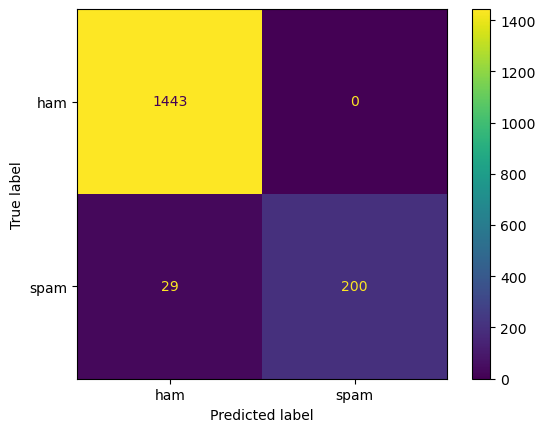

In [9]:
#fit and transform training and test data
vectorizer = TfidfVectorizer(min_df=3)

train_transformed = vectorizer.fit_transform(sms_train)

test_transformed = vectorizer.transform(sms_test)
        
#SVM classifier creation
clf = SVC()
clf.fit(train_transformed, label_train)

#assign predictor
train_predict = clf.predict(test_transformed)

#assign true negatives, false postives, false negatives and true positives in confusion matrix
tn, fp, fn, tp = confusion_matrix(label_test, train_predict).ravel()

#assign variable to confusion matrix and print confusion matrix metrics

conf_mat = confusion_matrix(label_test, train_predict, labels = [1,0])
print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')
print(f'True Positive Rate: { round((tp / (tp + fn))*100, 2)}%')
print(f'Specificity: { round((tn / (tn + fp))*100, 2)}%')
print(f'False Positive Rate: { round((fp / (fp + tn))*100, 2)}%')

cm_display = metrics.ConfusionMatrixDisplay(conf_mat, display_labels = ['ham', 'spam'])

cm_display.plot()
plt.show()